In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [2]:
dataFrame = pd.read_csv("pima_native_american_diabetes_dataset.csv")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F1ED47A240>,
      dtype=object)

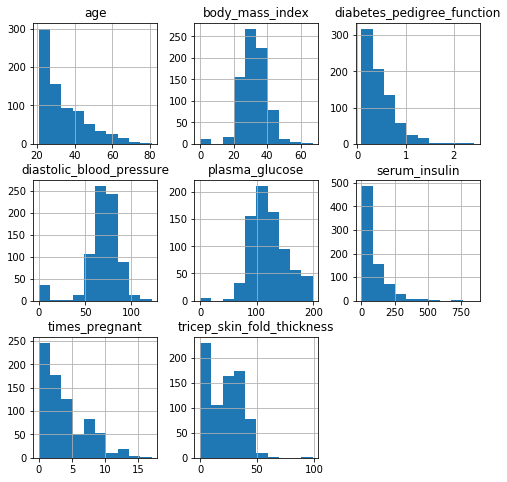

In [3]:
# DataFrame Visualization
dataFrame.iloc[:,0:8].hist(figsize=(8,8))

C:\Users\Ali\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Ali\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


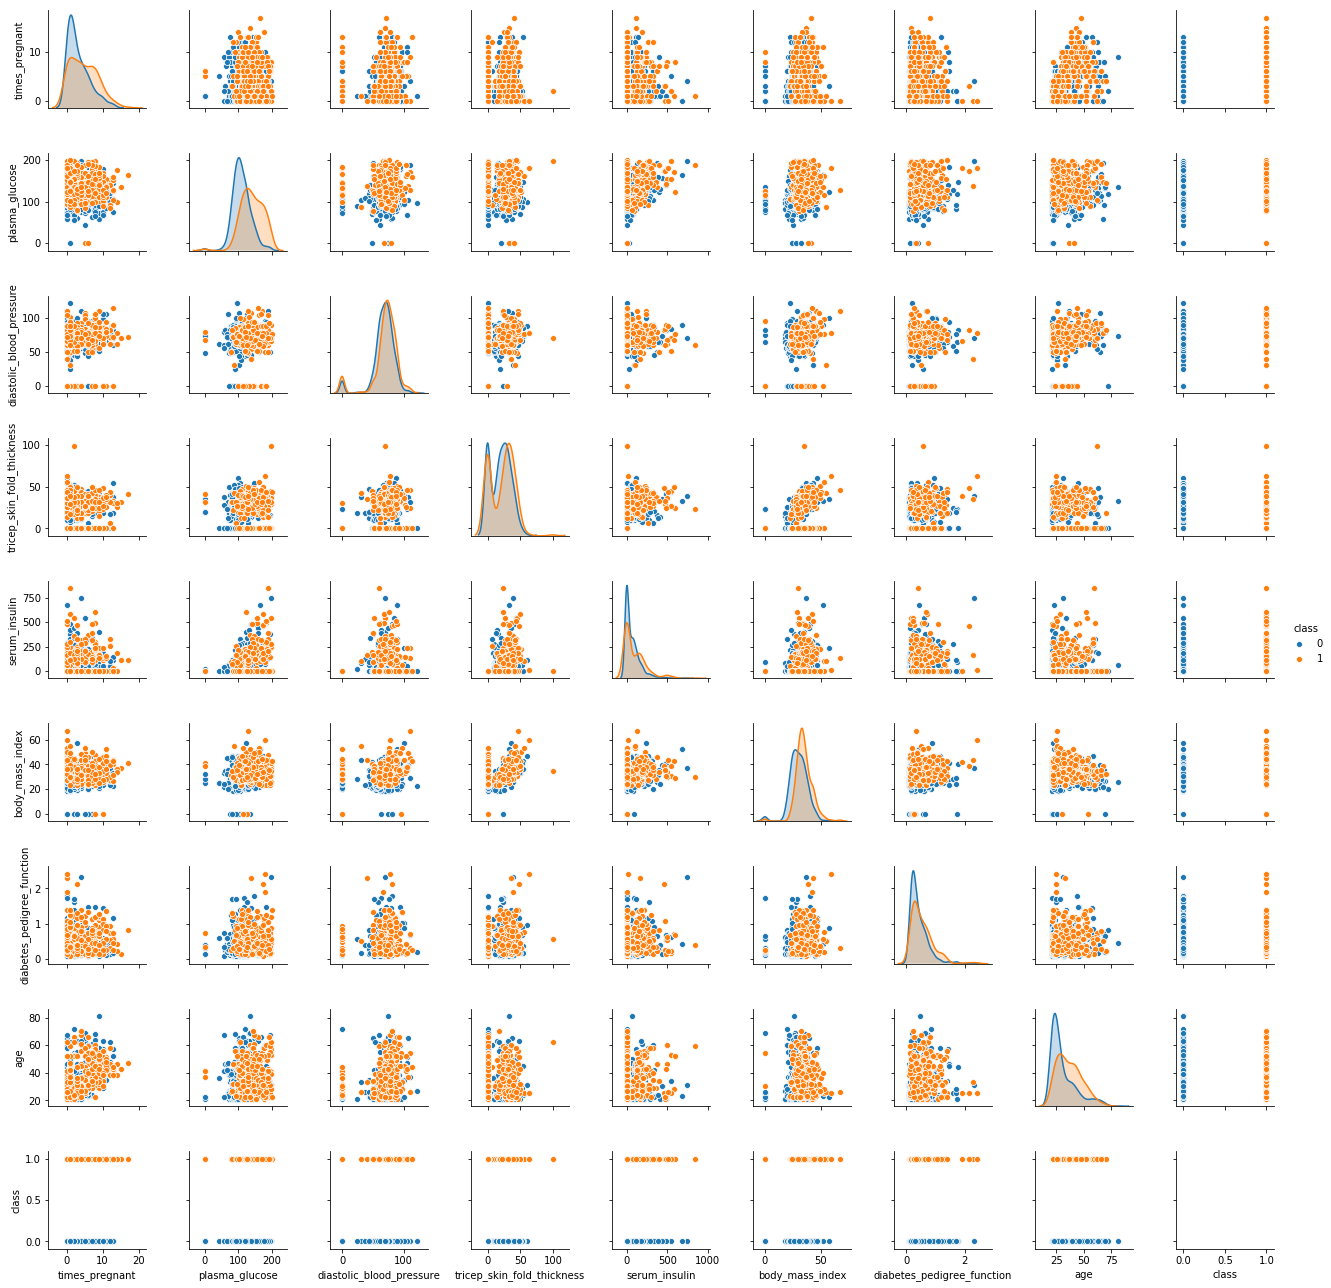

In [4]:
# Data Visualization
sns.pairplot(dataFrame,hue="class",height=2)

In [5]:
groundTruth = dataFrame["class"]
trainDataFrame = dataFrame.drop(columns=["class"])

In [6]:
# Outlier Remove
def removeOutlier(trainDataFrame, groundTruth, outlierThreshold):
    indexOfInlier =np.all(stats.zscore(trainDataFrame)<outlierThreshold,axis=1)
    return pd.concat([trainDataFrame.iloc[indexOfInlier], groundTruth.iloc[indexOfInlier]],axis = 1)

In [7]:
# Outlier Data
def outlierData(trainDataFrame, groundTruth, outlierThreshold):
    indexOfOutlier=np.all(stats.zscore(trainDataFrame)<outlierThreshold,axis=1)
    return pd.concat([trainDataFrame.iloc[~indexOfOutlier], groundTruth.iloc[~indexOfOutlier]],axis = 1)

In [8]:
cleanDataFrame = removeOutlier(trainDataFrame, groundTruth, 3)
outlierDataFrame = outlierData(trainDataFrame, groundTruth, 3)

In [9]:
cleanGroundTruth = cleanDataFrame["class"]
cleanTrainDataFrame = cleanDataFrame.drop(columns=["class"])
outlierGroundTruth = outlierDataFrame["class"]
outlierTrainDataFrame = outlierDataFrame.drop(columns=["class"])

In [10]:
X_train, X_test, y_train, y_test=train_test_split(cleanTrainDataFrame,cleanGroundTruth,test_size=0.15,random_state=42)
X_test = pd.concat([X_test, outlierTrainDataFrame])
y_test = pd.concat([y_test, outlierGroundTruth])

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 42)
X_test_val = pd.concat([X_test, X_val])
y_test_val = pd.concat([y_test, y_val])

## SVM Classifier

In [12]:
svmClassifier = svm.SVC(C=10,gamma=0.1,kernel='rbf')
svmScore = cross_val_score(svmClassifier, X_train, y_train, cv = 10, scoring='accuracy')
print("SVM Training Accuracy Score: ",svmScore.mean())
svmClassifier.fit(X_train,y_train)
svmPredict = svmClassifier.predict(X_test_val)
print("SVM Test Accuracy Score: ", accuracy_score(y_test_val, svmPredict))

SVM Training Accuracy Score:  0.6540127936354352
SVM Test Accuracy Score:  0.6446280991735537


In [13]:
confusion_matrix(y_test_val, svmPredict)

array([[156,   0],
       [ 86,   0]], dtype=int64)

## Random Forest Classifier

In [14]:
randomForestClassifier = RandomForestClassifier(n_estimators=400, max_depth=3, random_state=0)
randomForestScore = cross_val_score(randomForestClassifier, X_train, y_train, cv = 10, scoring='accuracy')
print("Random Forest Training Accuracy Score: ", randomForestScore.mean())
randomForestClassifier.fit(X_train, y_train)
randomForestPredict = randomForestClassifier.predict(X_test_val)
print("Random Forest Test Accuracy Score: ", accuracy_score(y_test_val, randomForestPredict))

Random Forest Training Accuracy Score:  0.7601663710154276
Random Forest Test Accuracy Score:  0.7892561983471075


In [15]:
confusion_matrix(y_test_val, randomForestPredict)

array([[139,  17],
       [ 34,  52]], dtype=int64)

## XGBoost Classifier

In [16]:
xgbClassifier = xgb.XGBClassifier(learning_rate=0.01, max_depth=7, min_child_weight=5, booster='gbtree', gamma=0.1,
                             nthread=-1, reg_lambda = 0.1, reg_alpha = 1, n_estimators=600, n_jobs=-1)
xgbScore = cross_val_score(xgbClassifier, X_train, y_train, cv = 10, scoring='accuracy')
print("XGB Training Accuracy Score: ", xgbScore.mean())
xgbClassifier.fit(X_train, y_train, verbose=50, eval_metric='rmse', eval_set = [(X_val, y_val)])
xgbPredict = xgbClassifier.predict(X_test_val)
print("XGB Test Accuracy Score: ", accuracy_score(y_test_val, xgbPredict))

XGB Training Accuracy Score:  0.7527280546148472
[0]	validation_0-rmse:0.498429
[50]	validation_0-rmse:0.445587
[100]	validation_0-rmse:0.429074
[150]	validation_0-rmse:0.422903
[200]	validation_0-rmse:0.423864
[250]	validation_0-rmse:0.420747
[300]	validation_0-rmse:0.422794
[350]	validation_0-rmse:0.425051
[400]	validation_0-rmse:0.426893
[450]	validation_0-rmse:0.431274
[500]	validation_0-rmse:0.434476
[550]	validation_0-rmse:0.437161
[599]	validation_0-rmse:0.438456
XGB Test Accuracy Score:  0.743801652892562


In [17]:
confusion_matrix(y_test_val, xgbPredict)

array([[123,  33],
       [ 29,  57]], dtype=int64)